In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date, time
import pickle

import folium
from folium import plugins
from folium.plugins import HeatMap

from haversine import haversine

In [2]:
#run in ANACONDA PROMT
#conda install -c conda-forge folium 
#conda install -c conda-forge haversine 

#for pickle errors run "conda update pandas"

In [3]:
#pickle read in
df_LA_geo = pd.read_pickle("../data/LA_geo.pickle")
df_LA = pd.read_pickle("../data/LA.pickle")

In [4]:
#df_LA = pd.read_csv('../data/LA.csv') 
#df_LA_geo = pd.read_csv('../data/LA_geo.csv') 

In [5]:
df_LA_geo.head(2)

start_time            end_time  start_station_id  end_station_id  \
0 2018-01-01 00:04:00 2018-01-01 00:25:00              3063            3018   
1 2018-01-01 00:05:00 2018-01-01 00:25:00              3063            3018   

   bike_id user_type start_station_name end_station_name   trip_duration  \
0     5889   Walk-up    Pershing Square  Grand & Olympic 0 days 00:21:00   
1     6311   Walk-up    Pershing Square  Grand & Olympic 0 days 00:20:00   

   trip_duration_in_hours  start_lat   start_lon    end_lat     end_lon  
0                0.350000  34.048326 -118.253513  34.043732 -118.260139  
1                0.333333  34.048326 -118.253513  34.043732 -118.260139

**Prepeare the data**

In [6]:
#define LA center
center = np.array(['34.053691', '-118.242766'])

#prepeare dataframes
LA_stations = df_LA_geo[['start_station_name', 'start_lat', 'start_lon']]
LA_stations = LA_stations.drop_duplicates().reset_index(drop=True)
#round
LA_stations['start_lat'] = LA_stations['start_lat'].round(6)
LA_stations['start_lon'] = LA_stations['start_lon'].round(6)

LA_stations
print(len(LA_stations), "stations in LA.")

#creating lists with station names and coordinats
namelist = []
coordlist = []
#iterating over the stations and connect lat & lon
for index, row in LA_stations.iterrows():
    #check nan values
    if not (pd.isna(row['start_lat']) | pd.isna(row['start_lon'])):
        #print(row['start_station_name'])
        #print([row['start_lat'],row['start_lon']])
        namelist.append(row['start_station_name'])
        coordlist.append([row['start_lat'],row['start_lon']])    
df_LA_stations = pd.DataFrame(data={'station_name':namelist, 'coord':coordlist})
df_LA_stations.head(2)

132 stations in LA.


station_name                     coord
0  Pershing Square  [34.048326, -118.253513]
1  Grand & Olympic  [34.043732, -118.260139]

**Add station ids to "df_LA_stations"**

In [7]:
#get necessary data
df_station_id = df_LA_geo[['start_station_name', 'start_station_id']].drop_duplicates()
#join id to df but prevent "endless merge add" (trough repeated run of notebook)
df_merged = pd.DataFrame()
df_merged = df_LA_stations.merge(df_station_id, how='left', left_on='station_name', right_on='start_station_name').rename(columns={'start_station_id':'id'})
df_merged = df_merged[['station_name', 'coord', 'id']]
df_LA_stations = df_merged.loc[:,~df_merged.columns.duplicated()]
#round the coord column

df_LA_stations.head(2)

station_name                     coord    id
0  Pershing Square  [34.048326, -118.253513]  3063
1  Grand & Olympic  [34.043732, -118.260139]  3018

**Add origin and destination column to df_trips**

In [8]:
#add origin and destination column to df_trips
df_trips = df_LA_geo
df_trips = df_trips.dropna()
#round
df_trips['start_lat'] = df_trips['start_lat'].round(6)
df_trips['start_lon'] = df_trips['start_lon'].round(6)
df_trips['end_lat'] = df_trips['end_lat'].round(6)
df_trips['end_lon'] = df_trips['end_lon'].round(6)
df_trips = df_trips.assign(orig=df_trips.apply(lambda x: [x['start_lat'],x['start_lon']],axis=1))
df_trips = df_trips.assign(dest=df_trips.apply(lambda x: [x['end_lat'],x['end_lon']],axis=1))
df_trips.head(2)

<ipython-input-8-2701d0911b7d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trips['start_lat'] = df_trips['start_lat'].round(6)
<ipython-input-8-2701d0911b7d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trips['start_lon'] = df_trips['start_lon'].round(6)
<ipython-input-8-2701d0911b7d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

start_time            end_time  start_station_id  end_station_id  \
0 2018-01-01 00:04:00 2018-01-01 00:25:00              3063            3018   
1 2018-01-01 00:05:00 2018-01-01 00:25:00              3063            3018   

   bike_id user_type start_station_name end_station_name   trip_duration  \
0     5889   Walk-up    Pershing Square  Grand & Olympic 0 days 00:21:00   
1     6311   Walk-up    Pershing Square  Grand & Olympic 0 days 00:20:00   

   trip_duration_in_hours  start_lat   start_lon    end_lat     end_lon  \
0                0.350000  34.048326 -118.253513  34.043732 -118.260139   
1                0.333333  34.048326 -118.253513  34.043732 -118.260139   

                       orig                      dest  
0  [34.048326, -118.253513]  [34.043732, -118.260139]  
1  [34.048326, -118.253513]  [34.043732, -118.260139]

**Frequently used stations**

Draw ja bigger Circle for more frequently used stations

In [9]:
#get info about the most frequently used bike stations
df_LA_stations
#count the appereance of the stations
df_start_station = pd.DataFrame(df_LA_geo.groupby('start_station_id')['start_station_name'].count())
df_end_station=pd.DataFrame(df_LA_geo.groupby('end_station_id')['end_station_id'].count())

#sum the counted values
df_joined = df_start_station.join(df_end_station, lsuffix='start_station_id', rsuffix='end_station_id')
df_joined = df_joined.assign(total_count=df_joined['start_station_name']+df_joined['end_station_id'])
df_joined = df_joined.sort_values(by='total_count', ascending = False).head(5)
df_joined 

start_station_name  end_station_id  total_count
start_station_id                                                 
4214                           16293           13373        29666
3005                           12175           13252        25427
4215                            8525           15669        24194
4210                           11391            9907        21298
3014                            9084            9787        18871

**Bike Stations**

In [10]:
df_LA_stations

station_name                     coord    id
0                 Pershing Square  [34.048326, -118.253513]  3063
1                 Grand & Olympic  [34.043732, -118.260139]  3018
2       Washington & Abbot Kinney   [33.988419, -118.45163]  4204
3    Fair Oaks & Mercantile Alley   [34.145248, -118.15007]  4147
4                     Olive & 8th   [34.04554, -118.256668]  3006
..                            ...                       ...   ...
123           University & Hoover   [34.02404, -118.283409]  4245
124             28th & University  [34.027618, -118.280678]  4267
125                 Hoover & 32nd   [34.02586, -118.284103]  4273
126                Mariachi Plaza   [34.04739, -118.218849]  4276
127                Expo Park/LAFC   [34.01252, -118.285896]  4275

[128 rows x 3 columns]

In [11]:
###########################################CHANGED##########################################
def bikestation_map(location, df_stations):
    bikestation_map = folium.Map(
        location=location, 
        tiles='OpenStreetMap', 
        zoom_start=11, 
        control_scale=True, 
        max_zoom=20)
    # add station point map
    for index, row in df_stations.iterrows():
        folium.CircleMarker(
            radius=5,
            location=row['coord'],
            popup=row['station_name'], 
            color='crimson', 
            alpha=0.2,
            fill_color='crimson'
        ).add_to(bikestation_map)
    return bikestation_map

In [12]:
bikestation_map(center, df_LA_stations)

**Heatmap to find the best coverage (highest density of bike stations) in the city**

In [13]:
def heat_map(df, station_id):
    # define new map
    heat_map = folium.Map(
        location=center, 
        tiles='OpenStreetMap', 
        zoom_start=11, 
        control_scale=True, 
        max_zoom=20)
    # add heat map
    heat_map.add_child(
        plugins.HeatMap(df['coord'], radius=20))
    #heat map for destination points looks pretty much identical
    return heat_map

In [14]:
heat_map(df_LA_stations, np.array(df_LA_stations['id']))

**Get location of top 5 frequently used stations by their id**

In [15]:
# define new map function
def getLocation(station_id):
    getLocation = folium.Map(
        location=center, 
        tiles='OpenStreetMap', 
        zoom_start=11, 
        control_scale=True, 
        max_zoom=20)
    # add station point map
    for station in station_id:
        geo = df_LA_stations.coord[df_LA_stations['id'] == station].values[0]
        #print(geo)
        folium.CircleMarker(
            radius=5,
            location=geo,
            popup='Station ID: '+ str(station), 
            color='crimson', 
            alpha=0.2,
            fill_color='crimson'
        ).add_to(getLocation)
    return getLocation

In [16]:
#top 5 stations
getLocation([4214, 3005, 4215, 4210, 3014])

**Trip Movement**

In [17]:
def trips_map(origins_list, origin_namelist, destinations_list, destination_namelist): 
    # define new map
    trips_map = folium.Map(
        location=center,  
        tiles='OpenStreetMap', 
        zoom_start=11, 
        control_scale=True, 
        max_zoom=20,
        height=1000)

    #draw trips
    for orig, orign, dest, destn in zip(origins_list, origin_namelist, destinations_list, destination_namelist):
        # Origin point
        #print(orig)
        folium.CircleMarker(
            radius=5,
            location=orig,
            popup=orign, 
            color='crimson', 
            alpha=0.2,
            fill_color='crimson').add_to(trips_map)
        # Destination point
        #print(dest)
        folium.CircleMarker(
            radius=5,
            location=dest,
            popup=destn, 
            color='blue', 
            alpha=0.2,
            fill_color='blue').add_to(trips_map)
        # Trip movement
        folium.PolyLine(
            (orig, dest),
            color="gray", 
            weight=1, 
            opacity=1).add_to(trips_map)
    return trips_map

First slice the dataframe to reduce the number of entrys

In [18]:
###########SLICING###################
#first 1000 trips
df_trips_sliced = df_trips.iloc[:1000,:]

#all trips of one station (e.g. most frequently used station --> 4214)
station_id = 4214

###########SLICING###################

#columns as list
orig_list = df_trips_sliced['orig'].tolist()
orig_name = df_trips_sliced['start_station_name'].tolist()
dest_list = df_trips_sliced['dest'].tolist()
dest_name = df_trips_sliced['end_station_name'].tolist()

#warning when you want to print to many trips
if(len(df_trips_sliced) > 1000):
    print('Runtime warning: You are going to print ' + str(len(df_trips_sliced))+ ' trips. Recommended are trips < 1000.')

#trip map
trips_map(orig_list,orig_name, dest_list, dest_name)

# KPI: Stündliche durchschnittliche Zeit zwischen zwei Trips (durchschnittliche Stillstandszeit der Fahrräder)


In [19]:
#initial df transformations
df_waiting = df_LA
df_waiting = df_waiting.sort_values(by=['bike_id','start_time'], ascending=True)
df_waiting = df_waiting[['start_time','end_time', 'bike_id']]

#add columns next_ride_start and next_bike_id which contain the shifted columns
df_waiting = df_waiting.assign(next_ride_start=0)
df_waiting['next_ride_start']= df_waiting['start_time'].shift(periods=-1)
df_waiting = df_waiting.assign(next_bike_id=0)
df_waiting['next_bike_id']= df_waiting['bike_id'].shift(periods=-1)

#add column which contains a bool value to sign if the next entry is still about the same bike (condition for comparison)
df_waiting['id_compare'] = df_waiting.apply(lambda x: True if ((x['bike_id'] == x['next_bike_id'])) else False, axis=1)
df_waiting = df_waiting.dropna() #drop last row because of nan

#filter: only entrys with id_compare == True
df_waiting = df_waiting[df_waiting['id_compare']== True]

#calc the unused time only when id_compare == True (-->same bike is used in next trip)
df_waiting['waiting_time'] = df_waiting.apply(lambda x: x['next_ride_start'] - x['end_time'], axis=1)

df_waiting.head(2)

start_time            end_time  bike_id     next_ride_start  \
299 2018-01-01 12:39:00 2018-01-01 12:58:00     4727 2018-01-01 14:12:00   
422 2018-01-01 14:12:00 2018-01-01 14:13:00     4727 2018-01-05 10:33:00   

     next_bike_id  id_compare    waiting_time  
299        4727.0        True 0 days 01:14:00  
422        4727.0        True 3 days 20:20:00

**Average waiting time for each bike**

In [20]:
#group by: Average waiting time for bike 
df_avg_waiting = df_waiting.groupby(by='bike_id').agg({'waiting_time': pd.Series.mean})
df_avg_waiting = df_avg_waiting.reset_index()

#round to seconds
df_avg_waiting['waiting_time'] = df_avg_waiting['waiting_time'].dt.round(freq='s')

#bikes with longest average waiting time
df_avg_waiting.sort_values(by='waiting_time', ascending = False).head(5)

bike_id     waiting_time
486      6225 36 days 01:40:20
867      6628 18 days 04:58:04
1348    12374 17 days 20:00:26
159      5876 17 days 15:41:17
147      5864 17 days 12:02:15

**Average hourly waiting time**

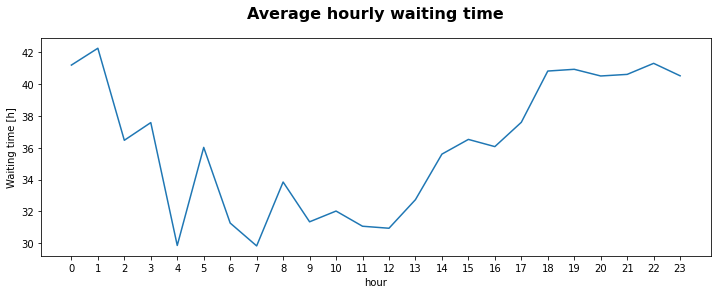

In [21]:
#group by: Average waiting time for bike 
df_hou_waiting = df_waiting
df_hou_waiting = df_hou_waiting.sort_values(by='start_time')

#add hour column to df
df_hou_waiting = df_hou_waiting.assign(hour=df_hou_waiting['start_time'].dt.hour)

#group by hour
df_hou_waiting_grouped = df_hou_waiting.groupby(by='hour').agg({'waiting_time': pd.Series.mean})

#round to seconds
df_hou_waiting_grouped['waiting_time'] = df_hou_waiting_grouped['waiting_time'].dt.round(freq='s')

#waiting time in hours
df_hou_waiting_grouped = df_hou_waiting_grouped['waiting_time'] / pd.Timedelta(hours=1)

#plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Average hourly waiting time", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("hour")
ax.set_xticks(np.arange(len(df_hou_waiting_grouped)))
ax.set_ylabel("Waiting time [h]")

ax.plot(df_hou_waiting_grouped)
plt.show()

**Average monthly waiting time**

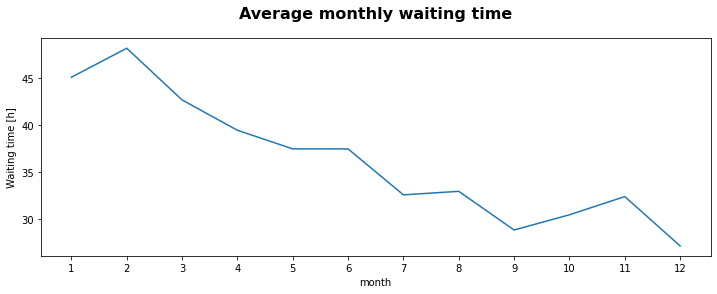

In [22]:
#group by: Average waiting time for bike 
df_mon_waiting = df_waiting
df_mon_waiting = df_mon_waiting.sort_values(by='start_time')

#add month column to df
df_mon_waiting = df_mon_waiting.assign(month=df_hou_waiting['start_time'].dt.month)

#group by month
df_mon_waiting_grouped = df_mon_waiting.groupby(by='month').agg({'waiting_time': pd.Series.mean})

#round to seconds
df_mon_waiting_grouped['waiting_time'] = df_mon_waiting_grouped['waiting_time'].dt.round(freq='s')

#waiting time in hours
df_mon_waiting_grouped = df_mon_waiting_grouped['waiting_time'] / pd.Timedelta(hours=1)

#plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Average monthly waiting time", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("month")
ax.set_xticks(np.arange(len(df_mon_waiting_grouped)+1))
ax.set_ylabel("Waiting time [h]")

ax.plot(df_mon_waiting_grouped)
plt.show()

# Dataset exploration / Potentional KPIs

In [23]:
#Partitional clustering
#Hierarchical clustering
#Density-based clustering

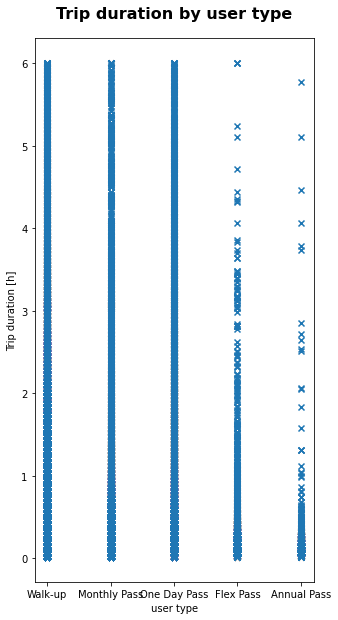

In [24]:
#plot
fig, ax = plt.subplots(figsize=(5, 10))
ax.set_title("Trip duration by user type", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("user type")
#ax.set_xticks(np.arange(len(df_mon_waiting_grouped)+1))
ax.set_ylabel("Trip duration [h]")

ax.scatter(x=df_LA['user_type'], y=df_LA['trip_duration_in_hours'], marker='x')
plt.show()


Text(0, 0.5, 'trip duration [h]')

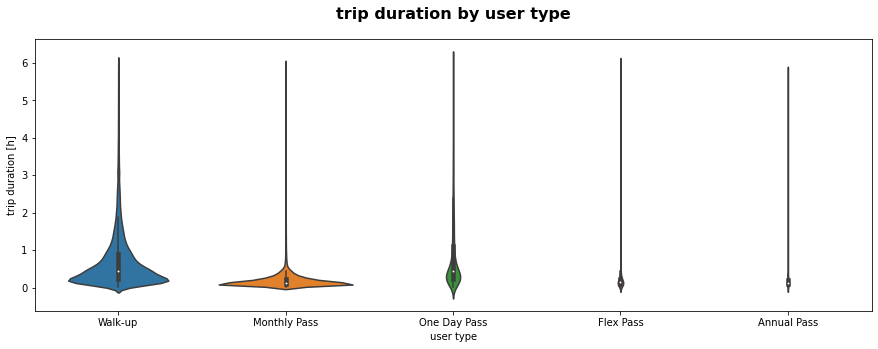

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(
    x=df_LA['user_type'],
    y=df_LA['trip_duration_in_hours'],
    scale="count")

ax.set_title("trip duration by user type", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("user type")
ax.set_ylabel("trip duration [h]")

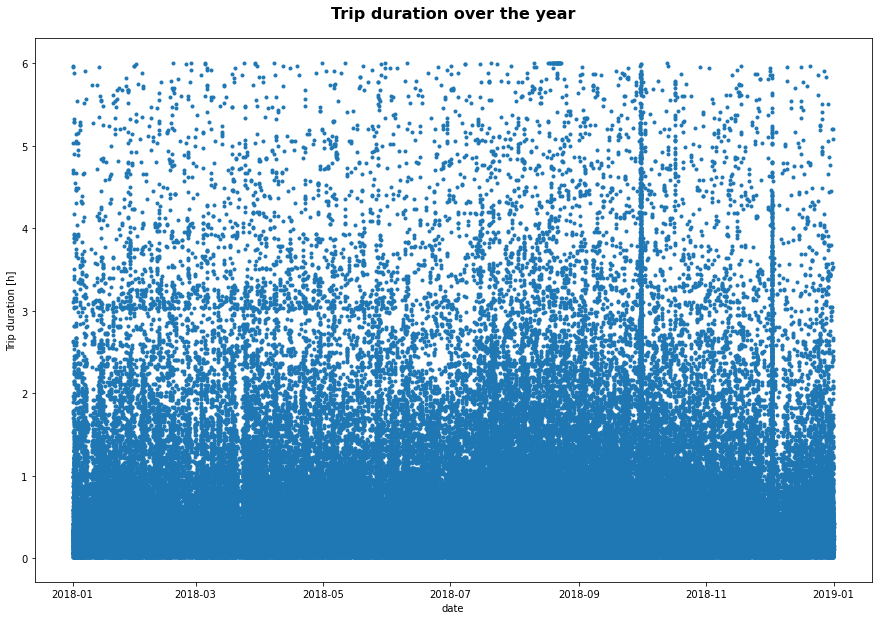

In [26]:
#plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Trip duration over the year", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("date")
#ax.set_xticks(np.arange(len(df_mon_waiting_grouped)+1))
ax.set_ylabel("Trip duration [h]")

ax.scatter(x=df_LA['start_time'], y=df_LA['trip_duration_in_hours'], marker='.')
plt.show()

#plt.scatter(x=df_LA['start_time'], y=df_LA['trip_duration_in_hours'])

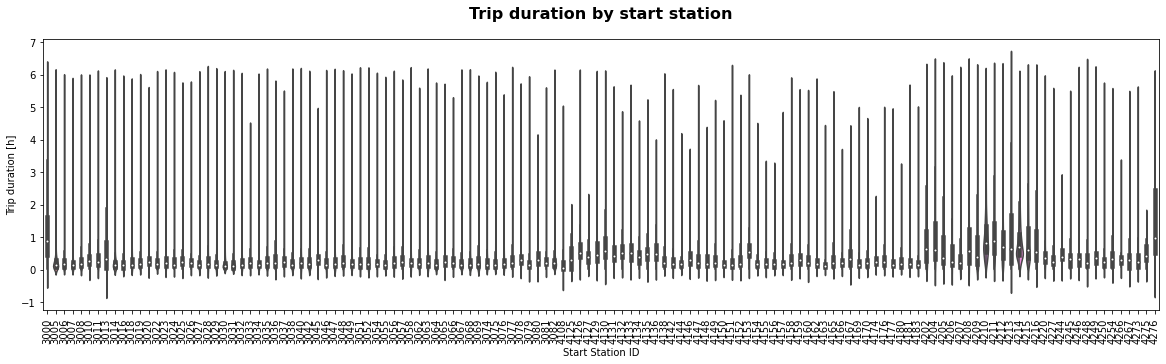

In [27]:
# Trip duration by start station id
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title("Trip duration by start station", fontsize=16, fontweight="bold", pad=20)
sns.violinplot(x=df_LA['start_station_id'], y=df_LA['trip_duration_in_hours'], ax=ax, scale="count")
ax.set_ylabel("Trip duration [h]")
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("Start Station ID")
plt.show()

# K-means Clustering
